# Using a CNN to Classify ASL Letters

## Introduction

**Purpose:** Our goal with this notebook is to create a model that can most accurately identify letters in the American sign language. The use of ML in translating ASL is a very practical use case. Creating a model that could do this accurately could benefit as communication aid to many people in the deaf and hard of hearing communities. In the case of out particular situation, we want to see how removing the noise of the background in our data can effect training times and accuracy, leading to better realtime translation of ASL to written text.

**Constraints and Parameters:** 
1. Our Set contains over 200k+ images
2. Non-Segmented model can be seen as baseline
3. CNN model, explore optimal architectures 

**Research Question:** Does Segmenting ASL Images lead to better overall accuracy and training times then non-segmented data?

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, random_split, DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
#base import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random as rand
import cv2
import imghdr
from PIL import Image
import os
from sklearn.utils import shuffle

/var/folders/9r/49b21tr5095dwzypsszmqb2r0000gn/T/ipykernel_64815/2785240529.py:8: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
# evalutation imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Data Distribution

As seen below our data was for the most part evenly distributed between classes. In our segmented data where we controlled the exact number, we created a perfectly even split between the letters. Our one slight outlier, the nothing image, I believe will not have an impact on our model due to its very distinct nature. 

Our non-segmented set contained 223074 images while the segmented contained 1/3 of that number, 86998. This provides us sufficient data for our model to be tested and trained on giving it the best chances at generalization.

In [ ]:

# basic variables

seed = 42
img_dim = 128

train_path = ("/Users/henry/Desktop/ASL_Alphabet_Dataset/asl_alphabet_train")
seg_path = ("/Users/henry/Desktop/als/ASL_SMALL_CROPPED/asl_alphabet_train/asl_alphabet_train")



transform = transforms.Compose([
    transforms.Resize((img_dim, img_dim)),
    transforms.ToTensor()

])

g = torch.Generator()
g.manual_seed(seed)
Rdataset = datasets.ImageFolder(root=train_path, transform=transform)
class_names = Rdataset.classes
print(len(class_names), len(Rdataset))
seg_set = datasets.ImageFolder(root=seg_path, transform=transform)
print(len(class_names), len(seg_set))
seg_names = seg_set.classes


29 223074
29 86998


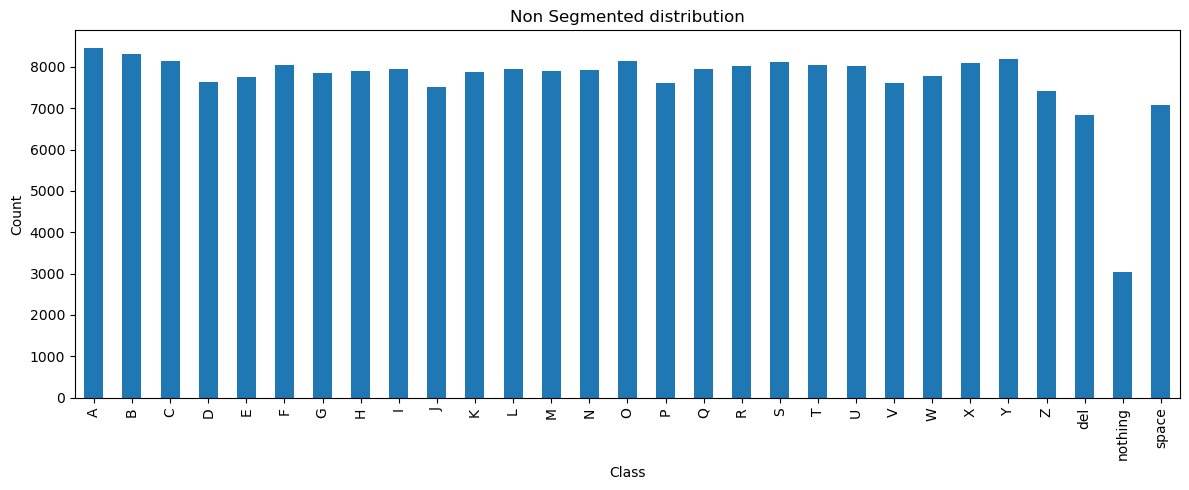

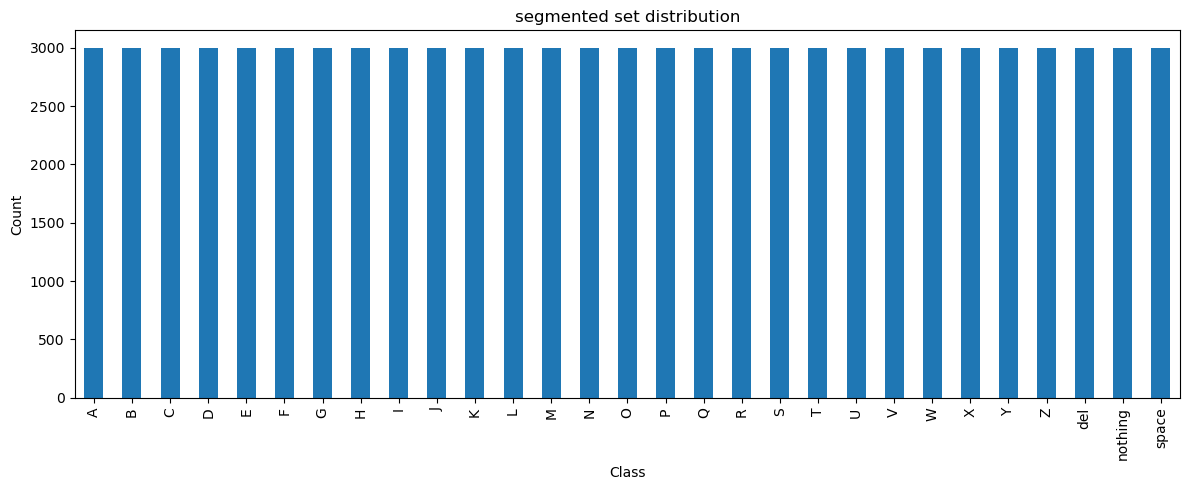

In [62]:
# data distribution
reg_df = pd.DataFrame(Rdataset.imgs, columns=["path", "class_idx"])
seg_df = pd.DataFrame(seg_set.imgs, columns=["path", "class_idx"])


reg_df['class_name'] = reg_df['class_idx'].apply(lambda x: Rdataset.classes[x])
seg_df['class_name'] = seg_df['class_idx'].apply(lambda x: seg_set.classes[x])


reg_df['class_name'].value_counts().sort_index().plot(kind='bar', figsize=(12, 5), title="Non Segmented distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


seg_df['class_name'].value_counts().sort_index().plot(kind='bar', figsize=(12, 5), title="segmented set distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()






In [63]:
class_names = (
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
    'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'del', 'nothing', 'space'
)

In [ ]:
def get_mean_std(dataset):
    means = torch.zeros(3)
    stds = torch.zeros(3)
    for img, _ in dataset:
        for c in range(3):
            means[c] += torch.mean(img[c])
            stds[c] += torch.std(img[c])

    num_images = len(dataset)
    means /= num_images
    stds /= num_images

    return means, stds

mean, std = get_mean_std(Rdataset)
print(f"Mean: {mean}, Standard Deviation: {std}")

normalize_transform = transforms.Compose([
    transforms.Resize((img_dim, img_dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = datasets.ImageFolder(root=train_path, transform=normalize_transform)

Mean: tensor([0.5395, 0.5171, 0.5226]), Standard Deviation: tensor([0.1916, 0.2227, 0.2337])


## Dataset Segmentation

One of the major methods we used to preprocess this dataset was attempting to segment the hands out of background of the image. Optimally, this would reduce the amount of "trash input" into our CNN, increasing the accuracy of the resulting prediction.

To achieve this, we used a python library called Rembg, which provides an easy pipeline and some pre-trained models specialized for background removal. We chose to use their U^2-Net implementation, as we found it provided the best results out of the available models (even better than the one specialized for human segmentation, ironically).

In [ ]:
# segmentation imports
from pathlib import Path
from rembg import remove, new_session

In [ ]:

input_root = Path('Data/ASL_SMALL/asl_alphabet_train/asl_alphabet_train/')
output_root = Path('Data/ASL_SMALL_CROPPED/asl_alphabet_train/asl_alphabet_train/')

for folder in input_root.iterdir():
    session = new_session(model_name="u2net")
    output_folder = output_root / folder.name
    output_folder.mkdir(parents=True, exist_ok=True)
    for file in folder.glob('*.jpg'):
        input_path = str(file)
        print("Input: ", input_path)
        output_path = str(output_folder / (file.stem + ".png"))
        print(output_path)

        if os.path.exists(output_path):
            continue

        with open(input_path, 'rb') as i:
            input = i.read()
            output = remove(input, session=session, alpha_matting=False)
            with open(output_path, 'wb') as o:
                o.write(output)

Screenshot of segmentation process outputs (because we ran it separately from the main notebook and it takes way too long to run it again).
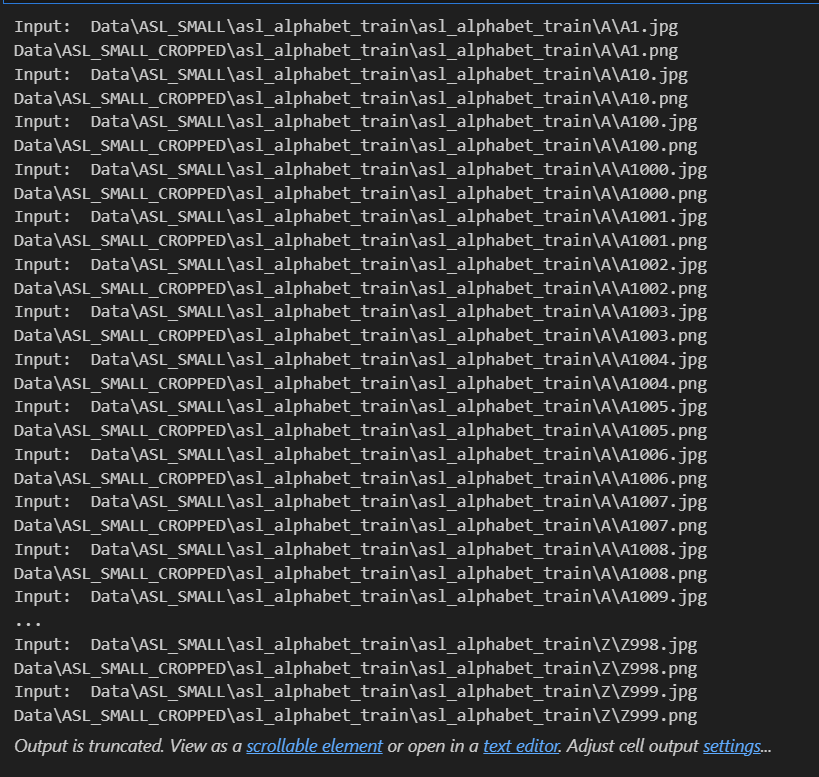

For most of the images we processed, this segmentation worked great. However, there were 2 main issues:

1. It took >10 hours to do 1/3 of the total dataset

This is the reason we settled on only doing this to a smaller version of the dataset rather than the full thing.

2. ~5% of the segmented images were either basically unreadable or literally unreadable

Some of the outputted images ended up being bad files, which necessitated the image verfication process seen below. A non-insignificant portion of the outputted images also had the hands either completely segmented out of them or horrifically melded with the background image. These images at best provide no useful data for our model, and at worst may even reduce the accuracy by introducing outliers/incorrect data to our training set.

In [9]:
from PIL import Image, UnidentifiedImageError
bad_files = []
for root, _, files in os.walk('/Users/henry/Desktop/als/ASL_SMALL_CROPPED'):
    for file in files:
        path = os.path.join(root, file)
        try:
            img = Image.open(path)
            img.verify()
        except (UnidentifiedImageError, OSError):
            print(f"Bad file: {path}")
            bad_files.append(path)


Bad file: /Users/henry/Desktop/als/ASL_SMALL_CROPPED/.DS_Store
Bad file: /Users/henry/Desktop/als/ASL_SMALL_CROPPED/asl_alphabet_test/.DS_Store
Bad file: /Users/henry/Desktop/als/ASL_SMALL_CROPPED/asl_alphabet_train/.DS_Store
Bad file: /Users/henry/Desktop/als/ASL_SMALL_CROPPED/asl_alphabet_train/asl_alphabet_train/.DS_Store
Bad file: /Users/henry/Desktop/als/ASL_SMALL_CROPPED/asl_alphabet_train/asl_alphabet_train/A/.DS_Store


In [65]:
def get_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    means = torch.zeros(3)
    stds = torch.zeros(3)
    num_images = 0

    for images, _ in loader:
        images = images.squeeze(0)
        for c in range(3):
            means[c] += torch.mean(images[c])
            stds[c] += torch.std(images[c])
        num_images += 1

    means /= num_images
    stds /= num_images

    return means, stds
segMean, segStd = get_mean_std(seg_set)
print(f"Segmented Mean: {segMean}, Segmented Standard Deviation: {segStd}")

Segmented Mean: tensor([0.0707, 0.0540, 0.0514]), Segmented Standard Deviation: tensor([0.1380, 0.1076, 0.1042])


In [66]:
seg_transform = transforms.Compose([
    transforms.Resize((img_dim, img_dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean=segMean, std=segStd)
])

seg_set = datasets.ImageFolder(root=seg_path, transform=seg_transform)

In [67]:
dataset.samples[200000]

('/Users/henry/Desktop/ASL_Alphabet_Dataset/asl_alphabet_train/Z/Z (2144).jpg',
 25)

In [68]:
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size], generator=g)

train_loader = DataLoader(train_set, batch_size=100, shuffle=True, generator=g, num_workers=2)
val_loader = DataLoader(val_set, batch_size=100, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=100, shuffle=True, num_workers=2)


print(f"Classes: {len(class_names)}")
print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")

Classes: 29
Train: 133844 | Val: 44614 | Test: 44616


In [69]:
seg_size = len(seg_set)
train_size = int(0.6 * seg_size)
val_size = int(0.2 * seg_size)
test_size = seg_size - train_size - val_size
seg_names = seg_set.classes
seg_train_set, seg_val_set, seg_test_set = random_split(seg_set, [train_size, val_size, test_size], generator=g)

seg_train_loader = DataLoader(seg_train_set, batch_size=100, shuffle=True, generator=g, num_workers=2)
seg_val_loader = DataLoader(seg_val_set, batch_size=100, shuffle=True, num_workers=2)
seg_test_loader = DataLoader(seg_test_set, batch_size=100, shuffle=True, num_workers=2)

print(f"Classes: {len(class_names)}")
print(f"Train: {len(seg_train_set)} | Val: {len(seg_val_set)} | Test: {len(seg_test_set)}")

Classes: 29
Train: 52198 | Val: 17399 | Test: 17401


In [70]:
image, label = train_set[0]
print(image.shape)

torch.Size([3, 128, 128])


## Data Examples

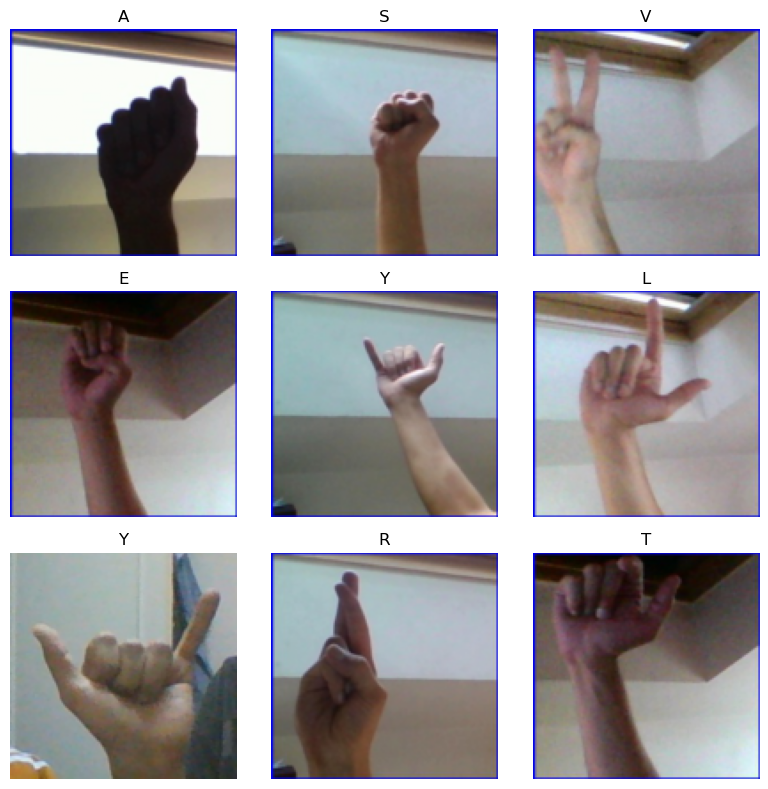

In [ ]:
# display some of the images
num_images = 9
rows, cols = 3, 3
plt.figure(figsize=(8, 8))
for i in range(num_images):
    image, label = dataset[rand.randint(0, len(dataset) - 1)]
    img = image.numpy().transpose((1, 2, 0))

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


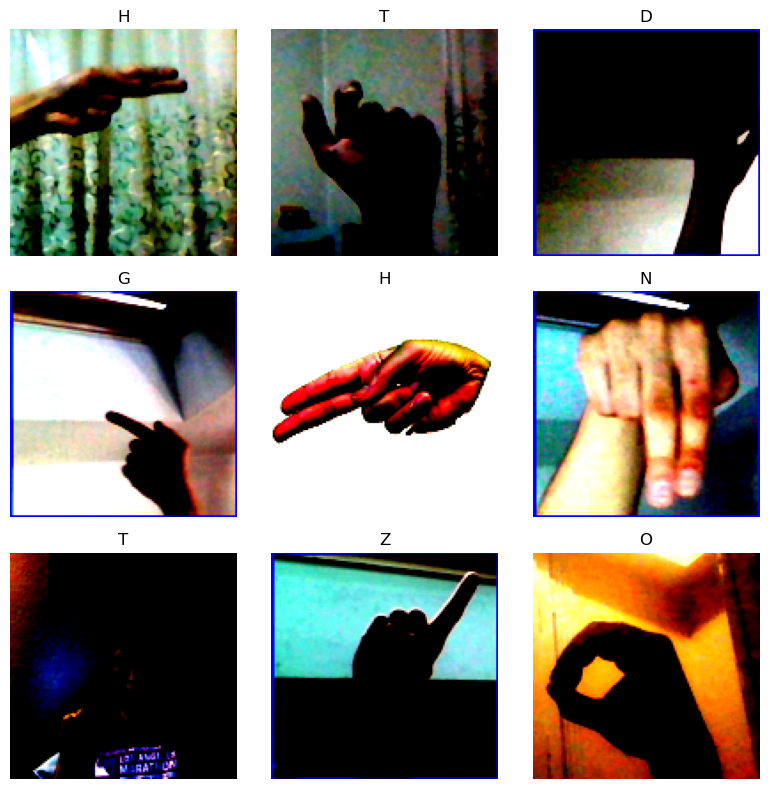

In [72]:
# display some of the images
num_images = 9
rows, cols = 3, 3
plt.figure(figsize=(8, 8))
for i in range(num_images):
    image, label = dataset[rand.randint(0, len(dataset) - 1)]
    img = image.numpy().transpose((1, 2, 0))

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

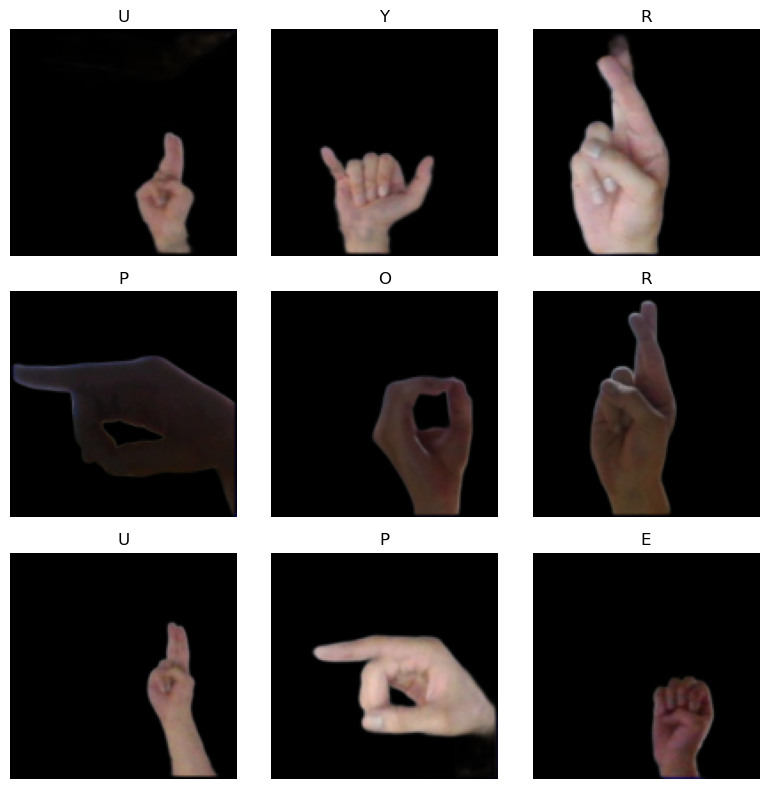

In [11]:
# display some of the images
num_images = 9
rows, cols = 3, 3
plt.figure(figsize=(8, 8))
for i in range(num_images):
    image, label = seg_set[rand.randint(0, len(seg_set) - 1)]
    img = image.numpy().transpose((1, 2, 0))

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(seg_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


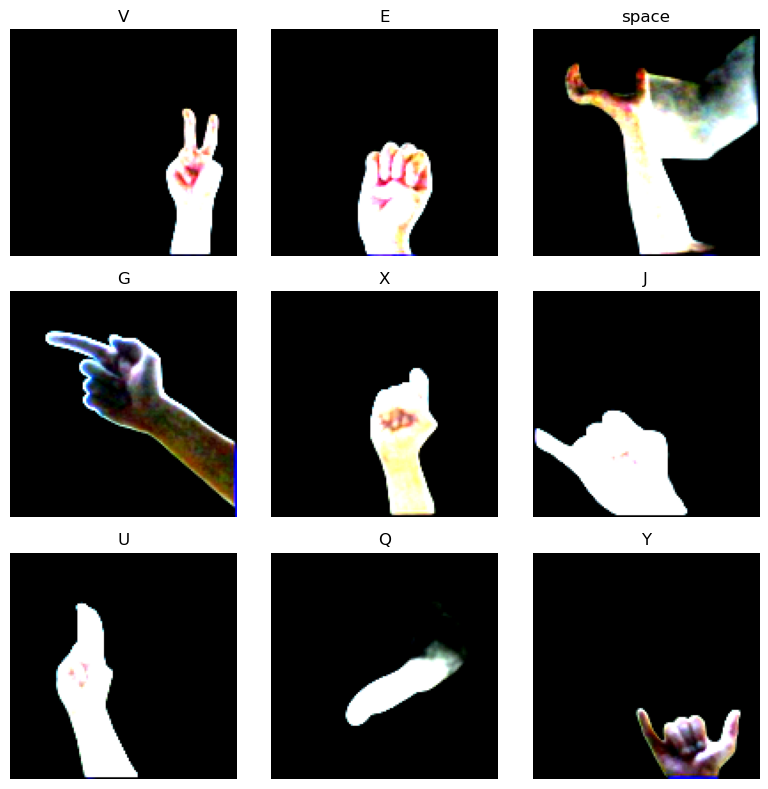

In [73]:
# display some of the images
num_images = 9
rows, cols = 3, 3
plt.figure(figsize=(8, 8))
for i in range(num_images):
    image, label = seg_set[rand.randint(0, len(seg_set) - 1)]
    img = image.numpy().transpose((1, 2, 0))

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(seg_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

## CNN Model

* A 3-layer Convolutional Neural Network (CNN) for classifying sign language from RGB images into 29 classes.
* Uses three convolutional blocks with increasing filters (32 -> 64 -> 128), each followed by ReLU activation and 2×2 max pooling to reduce spatial dimensions.
* The output feature maps are flattened into a 1D vector of size 128×16×16 for dense processing.
* Includes a fully connected layer at the end with 256 units, ReLU activation, and dropout (0.5) for regularization.
* Final output layer maps to 29 gesture classes using a linear transformation for classification.


In [74]:

def build_cnn_model(num_classes=29):
    class SignLanguageCNN(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
            self.pool1 = nn.MaxPool2d(2, 2)

            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
            self.pool2 = nn.MaxPool2d(2, 2)

            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
            self.pool3 = nn.MaxPool2d(2, 2)

            self.flattened_size = 128 * 16 * 16
            self.fc1 = nn.Linear(self.flattened_size, 256)
            self.dropout = nn.Dropout(0.5)
            self.fc2 = nn.Linear(256, num_classes)

        def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = self.pool3(F.relu(self.conv3(x)))
            x = x.view(-1, self.flattened_size)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    return SignLanguageCNN()


## CrossEntropy and Adam

In [75]:

def setup_training(model, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return criterion, optimizer


## Accuracy and Evaluation

In [76]:
# accuracy
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    return (100 * correct / total), cm


## Training Loops

Both sets of data (segmented and non segmented) were trained on the same architecture, learning rate, epoch number, and loss functions in order to  properly compare them. after each training epoch the model was evaluated on a validation set to measure its accuracy.

In the end both models were tested on a held out test set to calculate final accuracies. After each test set, a confusion matrix was created to see any potential patterns of misclassification.

In [77]:

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        val_acc, cm = evaluate(model, val_loader, device)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    print("Training finished.")


In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


## Non-Segmented Model

The Non Segmented model did incredibly well in our testing. The model recorded a top validation score of 99.09% and a final test score of 99.08%.

Looking at misclassifications, we see the models biggest inaccuracies were mistaking the sign for "T" for the sign "A" and mistaking "G" for the sign "H", Inserted below are the two hand signs, which makes it easy to see how they could get mixed up, both having the same overall shape. Despite this the model made these mistakes at very low rate.


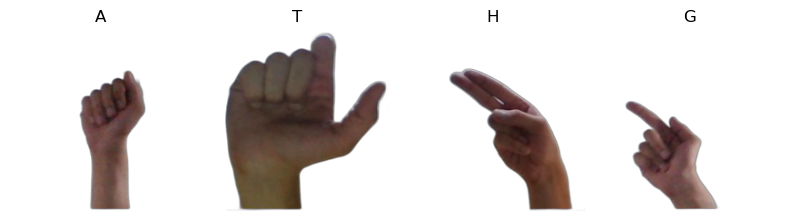

In [ ]:

G_path = "/Users/henry/Desktop/als/ASL_SMALL_CROPPED/asl_alphabet_train/asl_alphabet_train/G/G1786.png"
H_path = "/Users/henry/Desktop/als/ASL_SMALL_CROPPED/asl_alphabet_train/asl_alphabet_train/H/H530.png"
A_path = "/Users/henry/Desktop/als/ASL_SMALL_CROPPED/asl_alphabet_train/asl_alphabet_train/A/A1779.png"
T_path = "/Users/henry/Desktop/als/ASL_SMALL_CROPPED/asl_alphabet_train/asl_alphabet_train/T/T139.png"

image_paths = [A_path, T_path, H_path, G_path]
labels = ["A", "T", "H", "G"]
plt.figure(figsize=(8, 4))

for i, (path, label) in enumerate(zip(image_paths, labels)):
    img = Image.open(path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [82]:
model = build_cnn_model(num_classes=29)
criterion, optimizer = setup_training(model, learning_rate=0.001) 

train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)


Epoch [1/10] - Loss: 1446.9194, Train Acc: 66.12%, Val Acc: 93.29%
Epoch [2/10] - Loss: 491.4971, Train Acc: 87.92%, Val Acc: 96.79%
Epoch [3/10] - Loss: 325.2584, Train Acc: 91.89%, Val Acc: 97.69%
Epoch [4/10] - Loss: 246.9835, Train Acc: 93.81%, Val Acc: 98.37%
Epoch [5/10] - Loss: 201.8883, Train Acc: 94.99%, Val Acc: 98.59%
Epoch [6/10] - Loss: 170.5210, Train Acc: 95.71%, Val Acc: 98.76%
Epoch [7/10] - Loss: 148.8134, Train Acc: 96.24%, Val Acc: 98.78%
Epoch [8/10] - Loss: 130.7645, Train Acc: 96.73%, Val Acc: 98.96%
Epoch [9/10] - Loss: 118.9239, Train Acc: 97.06%, Val Acc: 99.01%
Epoch [10/10] - Loss: 110.4646, Train Acc: 97.31%, Val Acc: 99.09%
Training finished.


In [83]:
test_acc, cm_raw = evaluate(model, test_loader, device)
print(f'Final Test Accuracy: {test_acc:.2f}%')


Final Test Accuracy: 99.08%


In [84]:
# confusion matrix
cm_raw = pd.DataFrame(cm_raw, index=class_names, columns=class_names)

cm_raw

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,del,nothing,space
A,1670,2,5,3,0,0,0,0,0,2,0,0,0,2,0,0,1,1,2,20,0,0,0,0,2,0,0,0,0
B,1,1637,2,2,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0
C,1,1,1555,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
D,0,1,3,1545,0,0,0,1,1,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
E,0,0,1,7,1482,0,0,0,0,0,0,0,1,1,2,0,0,0,5,1,0,0,0,0,0,0,0,0,0
F,3,0,0,0,2,1605,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,1
G,0,0,0,0,0,0,1544,15,0,3,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,2,1601,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1
I,3,0,0,0,0,1,0,0,1568,0,1,0,0,0,0,0,0,0,4,2,2,0,0,1,0,0,0,0,0
J,2,0,1,0,0,0,5,8,2,1434,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,0


## Segmented Model

The segmented data did surprisingly good given it was able to use 1/3 of the data as the non segmented model. The model recorded a top validation score of 98.75% and scored the exact same when exposed to the test set. One large takeaway is that the model was able to be trained in a third of the non-segmented train time while only sacrificing a 0.23% decrease in accuracy.

The model once again made the same misclassifications as the non-segmented model (for easy to see reasons). Refer back to the image above to get an idea of why this misclassification may have happened.

In [79]:
seg_model = build_cnn_model(num_classes=29)
criterion, optimizer = setup_training(seg_model, learning_rate=0.001) # Segmented Data

train_model(seg_model, seg_train_loader, seg_val_loader, criterion, optimizer, device, num_epochs=10)


Epoch [1/10] - Loss: 566.5332, Train Acc: 66.98%, Val Acc: 93.27%
Epoch [2/10] - Loss: 150.0293, Train Acc: 90.58%, Val Acc: 96.81%
Epoch [3/10] - Loss: 92.3772, Train Acc: 94.18%, Val Acc: 97.80%
Epoch [4/10] - Loss: 67.1485, Train Acc: 95.74%, Val Acc: 98.04%
Epoch [5/10] - Loss: 53.1666, Train Acc: 96.58%, Val Acc: 98.32%
Epoch [6/10] - Loss: 45.5565, Train Acc: 97.16%, Val Acc: 98.51%
Epoch [7/10] - Loss: 36.0335, Train Acc: 97.70%, Val Acc: 98.70%
Epoch [8/10] - Loss: 33.0488, Train Acc: 97.94%, Val Acc: 98.46%
Epoch [9/10] - Loss: 33.1575, Train Acc: 97.91%, Val Acc: 98.63%
Epoch [10/10] - Loss: 26.7076, Train Acc: 98.36%, Val Acc: 98.75%
Training finished.


In [80]:
test_acc, cm_seg_model = evaluate(seg_model, seg_test_loader, device)
print(f'Final Test Accuracy: {test_acc:.2f}%')


Final Test Accuracy: 98.75%


In [ ]:
# confusion matrix
cm_seg_model = pd.DataFrame(cm_seg_model, index=class_names, columns=class_names)
cm_seg_model

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,del,nothing,space
A,605,0,0,1,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
B,1,589,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
C,1,0,584,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0
D,5,0,0,577,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
E,4,1,0,2,575,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0
F,2,0,2,1,7,570,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,579,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,1,0,564,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
I,0,0,0,0,0,0,0,0,663,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
J,0,0,0,0,0,0,0,0,0,581,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0


## Conclusion 

Comparing our **Segmented** vs **Non-Segmented** models, we see that each has different advantages.

Starting with the non-segmented model, it was much easier to prepare data to be trained and evaluate on. The segmentation process is very costly as well as very prone to errors making it slightly impractical 

Despite the segmented models downfalls in difficulty of preprocessing, we still feel it was the better model. The lower amount of data needed for just as good as an accuracy allowed for 3x faster training speeds. Although its not as clear just how much the segmentation added to the accuracy of the model, the removal of excess noise in the image clearly made training more effective, even with less data. 

**Moving forward with our project**, we came up with a couple of places we would want to take it in the future:

1. Implement a realtime system to allow for classification of ASL through video
2. Train on more data for the segmented model and benchmark accuracies
3. Implement the model with ASL phrases, not just letters

**Research Conclusion:** Although promising results, we do not have enough evidence to say that segmentation leads to better results on accuracy of classifying the ASL alphabet. 